In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import fileinput, glob, os
import datetime as dt
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
#Import from stock_list.csv, filter by Universe=True and parse columns with dates:
stock_list = pd.read_csv('files/stock_list.csv', index_col=0, parse_dates=[1])
stock_list_incl = stock_list[stock_list.Universe0 == True]
stock_list_incl.TradeDate = pd.to_datetime(stock_list_incl.TradeDate, format='%Y%m%d')
stock_list_incl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1301 to 9997
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   EffectiveDate           2000 non-null   datetime64[ns]
 1   Name                    2000 non-null   object        
 2   Section/Products        2000 non-null   object        
 3   NewMarketSegment        2000 non-null   object        
 4   33SectorCode            2000 non-null   object        
 5   33SectorName            2000 non-null   object        
 6   17SectorCode            2000 non-null   object        
 7   17SectorName            2000 non-null   object        
 8   NewIndexSeriesSizeCode  2000 non-null   object        
 9   NewIndexSeriesSize      2000 non-null   object        
 10  TradeDate               2000 non-null   datetime64[ns]
 11  Close                   2000 non-null   float64       
 12  IssuedShares            2000 non-null   float

/Users/koytoora/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [3]:
stock_list_incl.head()

,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
SecuritiesCode,,,,,,,,,,,,,,,
1301,2021-12-30,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,2021-12-30,3080.0,10928283.0,3.365911e+10,True
1332,2021-12-30,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,2021-12-30,543.0,312430277.0,1.696496e+11,True
1333,2021-12-30,Maruha Nichiro Corporation,First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,2021-12-30,2405.0,52656910.0,1.266399e+11,True
1375,2021-12-30,"YUKIGUNI MAITAKE CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,6,TOPIX Small 1,2021-12-30,1196.0,39910700.0,4.773320e+10,True
1376,2021-12-30,"KANEKO SEEDS CO.,LTD.",First Section (Domestic),Standard Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,2021-12-30,1504.0,11772626.0,1.770603e+10,True


In [4]:
#Import from stock_prices.csv and parse columns with dates:
stock_prices = pd.read_csv('files/train_files/stock_prices.csv', index_col=0, parse_dates=[1])


In [5]:
stock_prices.dropna(inplace=True, subset=['Open','High','Low','Close','Target'])
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2324923 entries, 20170104_1301 to 20211203_9997
Data columns (total 11 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Date              datetime64[ns]
 1   SecuritiesCode    int64         
 2   Open              float64       
 3   High              float64       
 4   Low               float64       
 5   Close             float64       
 6   Volume            int64         
 7   AdjustmentFactor  float64       
 8   ExpectedDividend  float64       
 9   SupervisionFlag   bool          
 10  Target            float64       
dtypes: bool(1), datetime64[ns](1), float64(7), int64(2)
memory usage: 197.3+ MB


In [6]:
stock_prices.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
RowId,,,,,,,,,,,
20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [7]:
#Import from options.csv and parse columns with dates:
options = pd.read_csv('files/train_files/options.csv', index_col=0, parse_dates=[1],
                      converters={7:str,8:str,9:str,10:str})

In [8]:
#Correction of data types in some columns
options.LastTradingDay = pd.to_datetime(options.LastTradingDay, format='%Y%m%d')
options.SpecialQuotationDay = pd.to_datetime(options.SpecialQuotationDay, format='%Y%m%d')
options.NightSessionOpen = options.NightSessionOpen.str.replace('-','0')
options.NightSessionOpen = options.NightSessionOpen.astype('float')
options.NightSessionHigh = options.NightSessionHigh.str.replace('-','0')
options.NightSessionHigh = options.NightSessionHigh.astype('float')
options.NightSessionLow = options.NightSessionLow.str.replace('-','0')
options.NightSessionLow = options.NightSessionLow.astype('float')
options.NightSessionClose = options.NightSessionClose.str.replace('-','0')
options.NightSessionClose = options.NightSessionClose.astype('float')

In [9]:
options.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3567694 entries, 20170104_132010018 to 20211203_199248018
Data columns (total 30 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Date                 datetime64[ns]
 1   OptionsCode          int64         
 2   WholeDayOpen         float64       
 3   WholeDayHigh         float64       
 4   WholeDayLow          float64       
 5   WholeDayClose        float64       
 6   NightSessionOpen     float64       
 7   NightSessionHigh     float64       
 8   NightSessionLow      float64       
 9   NightSessionClose    float64       
 10  DaySessionOpen       float64       
 11  DaySessionHigh       float64       
 12  DaySessionLow        float64       
 13  DaySessionClose      float64       
 14  TradingVolume        int64         
 15  OpenInterest         int64         
 16  TradingValue         int64         
 17  ContractMonth        int64         
 18  StrikePrice          float64       
 19

In [10]:
#Import from trades.csv, drop NaNs, and parse columns with dates:
trades = pd.read_csv('files/train_files/trades.csv', parse_dates=[0,1,2])
trades_full = trades.dropna()

In [11]:
trades_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765 entries, 6 to 1710
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 765 non-null    datetime64[ns]
 1   StartDate                            765 non-null    datetime64[ns]
 2   EndDate                              765 non-null    datetime64[ns]
 3   Section                              765 non-null    object        
 4   TotalSales                           765 non-null    float64       
 5   TotalPurchases                       765 non-null    float64       
 6   TotalTotal                           765 non-null    float64       
 7   TotalBalance                         765 non-null    float64       
 8   ProprietarySales                     765 non-null    float64       
 9   ProprietaryPurchases                 765 non-null    float64       
 10  ProprietaryTo

In [12]:
#Import from financials.csv and parse dates:
financials = pd.read_csv('files/train_files/financials.csv', index_col=0, parse_dates=[2,4,8,10,11],
                        converters={14:str,15:str,16:str,17:str,18:str,19:str,42:str,44:str})

In [13]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 92956 entries, 20161207453651.0 to 20211203446277.0
Data columns (total 44 columns):
 #   Column                                                                        Non-Null Count  Dtype         
---  ------                                                                        --------------  -----         
 0   DateCode                                                                      92954 non-null  object        
 1   Date                                                                          92956 non-null  datetime64[ns]
 2   SecuritiesCode                                                                92954 non-null  float64       
 3   DisclosedDate                                                                 92954 non-null  datetime64[ns]
 4   DisclosedTime                                                                 92954 non-null  object        
 5   DisclosedUnixTime                                           

In [14]:
#Это бесполезные операции, сначала генерирурю список дней и акций, а потом джойном удаляю строки, для которых нет данных в stock_prices
#Просто потренировался, можно сразу брать индексы из stock_prices
date_range = pd.date_range(stock_prices.Date.min(), stock_prices.Date.max(), freq='D')
dates = np.array(date_range)
stocks = np.array(stock_list_incl.index)
multi_index = pd.MultiIndex.from_product([dates, stocks], names=['Date','SecuritiesCode'])
final_full = multi_index.to_frame(index = False)
final1 = final_full.merge(stock_prices.iloc[:,:], how='inner', on=['Date','SecuritiesCode'])
final1['AdjustmentFactor'] = final1.sort_values(by='Date').groupby('SecuritiesCode')['AdjustmentFactor'].shift(1)
final1['AdjustmentFactor'] = final1.sort_values(by='Date').groupby('SecuritiesCode')['AdjustmentFactor'].bfill()
final1['DoW'] = [i.weekday() for i in final1['Date']]
one_hot = pd.get_dummies(final1['DoW'])
final1 = final1.drop('DoW',axis = 1)
final1 = final1.join(one_hot)
final1 = final1.rename(columns={0: 'Mo',1: 'Tu',2: 'We',3: 'Th',4: 'Fr'})
final1[(final1.SecuritiesCode == 2590) & (final1.Date < '2017-02-01')]


,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Mo,Tu,We,Th,Fr
214,2017-01-04,2590,6100.0,6200.0,6090.0,6160.0,77400,1.0,NaN,False,-0.003200,0,0,1,0,0
2077,2017-01-05,2590,6170.0,6270.0,6150.0,6250.0,74500,1.0,NaN,False,-0.012841,0,0,0,1,0
3940,2017-01-06,2590,6270.0,6290.0,6170.0,6230.0,74500,1.0,NaN,False,-0.004878,0,0,0,0,1
5804,2017-01-10,2590,6210.0,6210.0,6120.0,6150.0,90100,1.0,NaN,False,-0.003268,0,1,0,0,0
7663,2017-01-11,2590,6140.0,6170.0,6110.0,6120.0,62200,1.0,NaN,False,-0.001639,0,0,1,0,0
9524,2017-01-12,2590,6110.0,6130.0,6060.0,6100.0,79700,1.0,NaN,False,-0.004926,0,0,0,1,0
11382,2017-01-13,2590,6050.0,6120.0,6050.0,6090.0,66100,1.0,NaN,False,-0.019802,0,0,0,0,1
13240,2017-01-16,2590,6060.0,6130.0,6060.0,6060.0,125800,1.0,30.0,False,0.005051,1,0,0,0,0
15097,2017-01-17,2590,6040.0,6050.0,5940.0,5940.0,243900,1.0,NaN,False,0.005025,0,1,0,0,0
16957,2017-01-18,2590,5900.0,5990.0,5860.0,5970.0,197000,1.0,NaN,False,-0.003333,0,0,1,0,0


In [15]:
#Магия
e = final1[final1.AdjustmentFactor != 1].set_index('Date').groupby(
    ['SecuritiesCode'])['AdjustmentFactor'].expanding(1).apply(np.prod)
e.name = 'CumFactor'
final2 = final1.merge(e, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
final2['CumFactor'] = final2.sort_values(by='Date').groupby(['SecuritiesCode'])['CumFactor'].fillna(method='ffill')
final2['CumFactor'] = final2['CumFactor'].fillna(1)
final2['Open'] = final2['Open'] / final2['CumFactor']
final2['High'] = final2['High'] / final2['CumFactor']
final2['Low'] = final2['Low'] / final2['CumFactor']
final2['Close'] = final2['Close'] / final2['CumFactor']
final2['Volume'] = final2['Volume'] * final2['CumFactor']
final2['ExpectedDividend'] = (final2['ExpectedDividend'] / final2['CumFactor'])
final2['DividendRatio'] = final2['ExpectedDividend'] / final2['Close']
final2['DividendRatio'] = final2['DividendRatio'].fillna(0)
#Вопрос: в чистом виде модель всегда будет советовать вставать в шорт перед экс-дивидендой датой, в реальной жизни это не имеет смысла
#так как либо это запрещено, либо с шортящих вычтут сумму дивидендов, но формула оценки модели этого не учитывает
#можно либо пользоваться этой дырой, либо из target вычитать DividendRatio, то есть если цена упадет больше чем на сумму дивидендов
#то мы окажемся в плюсе
final2[(final2.SecuritiesCode==3421) & (final2.Date < '2017-02-01')]

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Mo,Tu,We,Th,Fr,CumFactor,DividendRatio
390,2017-01-04,3421,1349.0,1363.0,1344.0,1361.0,30700.0,1.0,NaN,False,0.002935,0,0,1,0,0,1.0,0.000000
2253,2017-01-05,3421,1360.0,1367.0,1350.0,1363.0,21900.0,1.0,NaN,False,0.003658,0,0,0,1,0,1.0,0.000000
4116,2017-01-06,3421,1363.0,1370.0,1351.0,1367.0,20300.0,1.0,NaN,False,0.002915,0,0,0,0,1,1.0,0.000000
5979,2017-01-10,3421,1374.0,1375.0,1362.0,1372.0,30000.0,1.0,NaN,False,-0.001453,0,1,0,0,0,1.0,0.000000
7839,2017-01-11,3421,1376.0,1378.0,1371.0,1376.0,20300.0,1.0,NaN,False,0.000728,0,0,1,0,0,1.0,0.000000
9699,2017-01-12,3421,1372.0,1375.0,1357.0,1374.0,22500.0,1.0,NaN,False,-0.006545,0,0,0,1,0,1.0,0.000000
11558,2017-01-13,3421,1372.0,1375.0,1365.0,1375.0,17100.0,1.0,NaN,False,-0.008785,0,0,0,0,1,1.0,0.000000
13416,2017-01-16,3421,1375.0,1375.0,1365.0,1366.0,19100.0,1.0,NaN,False,-0.004431,1,0,0,0,0,1.0,0.000000
15273,2017-01-17,3421,1364.0,1364.0,1350.0,1354.0,19000.0,1.0,NaN,False,0.008160,0,1,0,0,0,1.0,0.000000
17133,2017-01-18,3421,1347.0,1351.0,1339.0,1348.0,22900.0,1.0,NaN,False,-0.001472,0,0,1,0,0,1.0,0.000000


In [16]:
#Скользящее среднее за 50 дней
sma50 = final2.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=50,min_periods=1).mean()
sma50.name = 'SMA50'
final3 = final2.merge(sma50, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#Скользящее среднее за 10 дней
sma10 = final3.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=10,min_periods=1).mean()
sma10.name = 'SMA10'
final4 = final3.merge(sma10, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#Относительная разница цен закрытия и скользящих средних
final4['SMA50_Close_diff'] = (final4.Close-final4.SMA50) / final4.Close
final4['SMA10_Close_diff'] = (final4.Close-final4.SMA10) / final4.Close
final4

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,...,Tu,We,Th,Fr,CumFactor,DividendRatio,SMA50,SMA10,SMA50_Close_diff,SMA10_Close_diff
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400.0,1.0,NaN,False,...,0,1,0,0,1.0,0.0,2742.00,2742.0,0.000000,0.000000
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500.0,1.0,NaN,False,...,0,1,0,0,1.0,0.0,571.00,571.0,0.000000,0.000000
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800.0,1.0,NaN,False,...,0,1,0,0,1.0,0.0,3210.00,3210.0,0.000000,0.000000
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300.0,1.0,NaN,False,...,0,1,0,0,1.0,0.0,1550.00,1550.0,0.000000,0.000000
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800.0,1.0,NaN,False,...,0,1,0,0,1.0,0.0,3330.00,3330.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,2021-12-03,9990,514.0,528.0,513.0,528.0,44200.0,1.0,NaN,False,...,0,0,0,1,1.0,0.0,564.04,537.8,-0.068258,-0.018561
2324919,2021-12-03,9991,782.0,794.0,782.0,794.0,35900.0,1.0,NaN,False,...,0,0,0,1,1.0,0.0,848.52,790.2,-0.068665,0.004786
2324920,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200.0,1.0,NaN,False,...,0,0,0,1,1.0,0.0,1715.06,1691.6,-0.042590,-0.028328
2324921,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500.0,1.0,NaN,False,...,0,0,0,1,1.0,0.0,2419.62,2376.0,-0.012817,0.005442


In [17]:
#Доля объемов на акцию от общедневного объема торговли
final4['USDVol'] = final4['Volume'] * final4['Close']
temp1 = final4.groupby('Date').agg('sum')['USDVol']
final4 = final4.rename(columns={'USDVol': 'ind_volume'})
final5 = final4.merge(temp1, how='left', left_on='Date', right_index=True)
final5 = final5.rename(columns={'USDVol': 'tot_volume'})
final5['Volume_share'] = final5['ind_volume'] / final5['tot_volume']
final5

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,...,Fr,CumFactor,DividendRatio,SMA50,SMA10,SMA50_Close_diff,SMA10_Close_diff,ind_volume,tot_volume,Volume_share
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400.0,1.0,NaN,False,...,0,1.0,0.0,2742.00,2742.0,0.000000,0.000000,8.609880e+07,2.665037e+12,0.000032
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500.0,1.0,NaN,False,...,0,1.0,0.0,571.00,571.0,0.000000,0.000000,1.597944e+09,2.665037e+12,0.000600
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800.0,1.0,NaN,False,...,0,1.0,0.0,3210.00,3210.0,0.000000,0.000000,8.692680e+08,2.665037e+12,0.000326
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300.0,1.0,NaN,False,...,0,1.0,0.0,1550.00,1550.0,0.000000,0.000000,1.751500e+07,2.665037e+12,0.000007
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800.0,1.0,NaN,False,...,0,1.0,0.0,3330.00,3330.0,0.000000,0.000000,5.021640e+08,2.665037e+12,0.000188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,2021-12-03,9990,514.0,528.0,513.0,528.0,44200.0,1.0,NaN,False,...,1,1.0,0.0,564.04,537.8,-0.068258,-0.018561,2.333760e+07,3.069473e+12,0.000008
2324919,2021-12-03,9991,782.0,794.0,782.0,794.0,35900.0,1.0,NaN,False,...,1,1.0,0.0,848.52,790.2,-0.068665,0.004786,2.850460e+07,3.069473e+12,0.000009
2324920,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200.0,1.0,NaN,False,...,1,1.0,0.0,1715.06,1691.6,-0.042590,-0.028328,1.184400e+07,3.069473e+12,0.000004
2324921,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500.0,1.0,NaN,False,...,1,1.0,0.0,2419.62,2376.0,-0.012817,0.005442,1.552850e+07,3.069473e+12,0.000005


In [18]:
#Полосы Боллинджера:
#средняя линия уже есть, это SMA10
#верхняя линия: средняя линия + (10 * стандартное отклонение цен закрытия за 10 дней)
#нижняя линия: средняя линия - (10 * стандартное отклонение цен закрытия за 10 дней)
sma10stdev = final5.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=10,min_periods=1).std()
sma10stdev.name = 'SD10'
final6 = final5.merge(sma10stdev, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
final6['Upper_line'] = final6['SMA10'] + final6['SD10']
final6['Lower_line'] = final6['SMA10'] - final6['SD10']
#относительная разница между ценой закрытия и нижней/верхней линиями
final6['UL_Close-diff'] = (final6.Close-final6.Upper_line) / final6.Close
final6['LL_Close-diff'] = (final6.Close-final6.Lower_line) / final6.Close
final6

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,...,SMA50_Close_diff,SMA10_Close_diff,ind_volume,tot_volume,Volume_share,SD10,Upper_line,Lower_line,UL_Close-diff,LL_Close-diff
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400.0,1.0,NaN,False,...,0.000000,0.000000,8.609880e+07,2.665037e+12,0.000032,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500.0,1.0,NaN,False,...,0.000000,0.000000,1.597944e+09,2.665037e+12,0.000600,NaN,NaN,NaN,NaN,NaN
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800.0,1.0,NaN,False,...,0.000000,0.000000,8.692680e+08,2.665037e+12,0.000326,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300.0,1.0,NaN,False,...,0.000000,0.000000,1.751500e+07,2.665037e+12,0.000007,NaN,NaN,NaN,NaN,NaN
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800.0,1.0,NaN,False,...,0.000000,0.000000,5.021640e+08,2.665037e+12,0.000188,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,2021-12-03,9990,514.0,528.0,513.0,528.0,44200.0,1.0,NaN,False,...,-0.068258,-0.018561,2.333760e+07,3.069473e+12,0.000008,19.153184,556.953184,518.646816,-0.054836,0.017714
2324919,2021-12-03,9991,782.0,794.0,782.0,794.0,35900.0,1.0,NaN,False,...,-0.068665,0.004786,2.850460e+07,3.069473e+12,0.000009,16.995424,807.195424,773.204576,-0.016619,0.026191
2324920,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200.0,1.0,NaN,False,...,-0.042590,-0.028328,1.184400e+07,3.069473e+12,0.000004,33.109918,1724.709918,1658.490082,-0.048456,-0.008201
2324921,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500.0,1.0,NaN,False,...,-0.012817,0.005442,1.552850e+07,3.069473e+12,0.000005,27.876713,2403.876713,2348.123287,-0.006227,0.017110


In [19]:
#RSI
#а) среднее значение последних 14 растущих дневных свечей
#б) среднее значение последних 14 падающих дневных свечей
#в) считаем RS: делим (а) на (б)
#г) считаем RSI: 100-(100/(1+RS))

last14up = final6[final6["Close"] > final6["Open"]].set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=14, min_periods=1).mean()
last14up.name = 'SMA14UP'
final7 = final6.merge(last14up, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
final7['SMA14UP'] = final7.sort_values(by='Date').groupby(['SecuritiesCode'])['SMA14UP'].fillna(method='ffill')
last14down = final7[final7["Close"] < final7["Open"]].set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=14, min_periods=1).mean()
last14down.name = 'SMA14DOWN'
final8 = final7.merge(last14down, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
final8['SMA14DOWN'] = final8.sort_values(by='Date').groupby(['SecuritiesCode'])['SMA14DOWN'].fillna(method='ffill')
final8['RSI'] = (100-(100/(1+(final8.SMA14UP / final8.SMA14DOWN))))/100
final8
final8[final8.SecuritiesCode == 9993].tail(20)
#last14up[9993].tail(20)


,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,...,tot_volume,Volume_share,SD10,Upper_line,Lower_line,UL_Close-diff,LL_Close-diff,SMA14UP,SMA14DOWN,RSI
2287036,2021-11-05,9993,1711.0,1726.0,1711.0,1718.0,1300.0,1.0,NaN,False,...,3.085648e+12,7.238026e-07,6.552353,1722.152353,1709.047647,-0.002417,0.005211,1735.071429,1711.642857,0.503399
2289032,2021-11-08,9993,1726.0,1730.0,1720.0,1720.0,1000.0,1.0,NaN,False,...,2.922434e+12,5.885505e-07,6.690790,1722.790790,1709.409210,-0.001623,0.006157,1735.071429,1711.071429,0.503482
2291024,2021-11-09,9993,1715.0,1721.0,1713.0,1717.0,2500.0,1.0,NaN,False,...,2.808725e+12,1.528274e-06,6.653320,1723.053320,1709.746680,-0.003526,0.004224,1732.214286,1711.071429,0.503070
2293017,2021-11-10,9993,1728.0,1728.0,1719.0,1719.0,2400.0,1.0,NaN,False,...,2.598415e+12,1.587737e-06,6.687468,1723.187468,1709.812532,-0.002436,0.005345,1732.214286,1711.071429,0.503070
2295005,2021-11-11,9993,1715.0,1715.0,1714.0,1714.0,300.0,1.0,NaN,False,...,2.594738e+12,1.981703e-07,3.604010,1721.504010,1714.295990,-0.004378,-0.000173,1732.214286,1711.214286,0.503049
2297001,2021-11-12,9993,1724.0,1724.0,1716.0,1721.0,1000.0,1.0,NaN,False,...,3.050659e+12,5.641404e-07,2.877113,1720.377113,1714.622887,0.000362,0.003705,1732.214286,1711.928571,0.502945
2298994,2021-11-15,9993,1717.0,1721.0,1714.0,1716.0,1100.0,1.0,NaN,False,...,2.768788e+12,6.817424e-07,2.766867,1719.866867,1714.333133,-0.002253,0.000971,1732.214286,1712.142857,0.502914
2300989,2021-11-16,9993,1727.0,1727.0,1718.0,1725.0,1500.0,1.0,NaN,False,...,2.842445e+12,9.103079e-07,3.489667,1721.689667,1714.710333,0.001919,0.005965,1732.214286,1712.785714,0.502820
2302979,2021-11-17,9993,1721.0,1733.0,1721.0,1721.0,2100.0,1.0,NaN,False,...,2.884425e+12,1.252971e-06,3.055050,1722.055050,1715.944950,-0.000613,0.002937,1732.214286,1712.785714,0.502820
2304971,2021-11-18,9993,1721.0,1726.0,1721.0,1722.0,1200.0,1.0,NaN,False,...,2.962226e+12,6.975834e-07,3.198958,1722.498958,1716.101042,-0.000290,0.003426,1729.071429,1712.785714,0.502366


<AxesSubplot:>

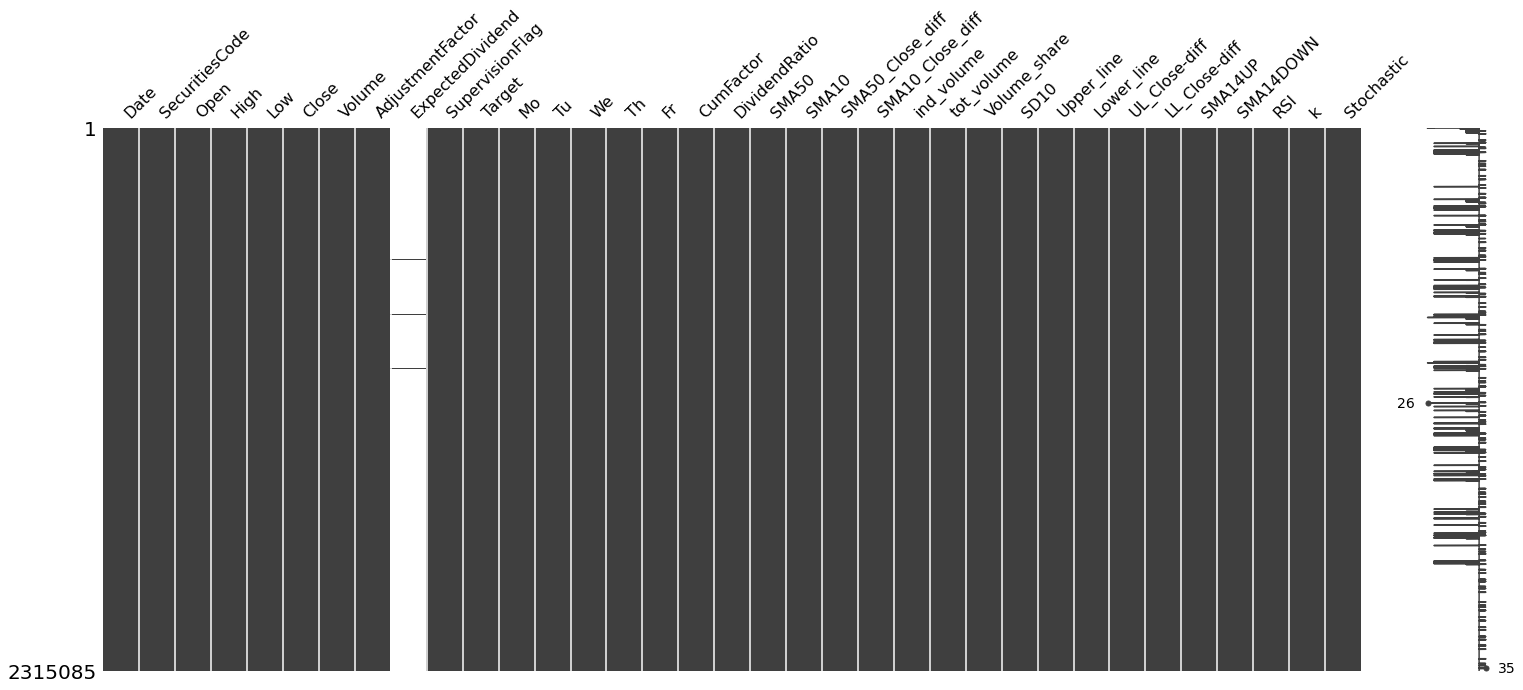

In [28]:
#Стохастический
#а) k = (цена закрытия - мин. цена дня)/(макс. цена дня - мин. цена дня)
#б) d = усредненная k за 3 дн
#теоретически возможно, что в знаменателе будет 0 три дня подряд и среднее не посчитается,
#на практике за 5 лет это не произошло ни разу, поэтому обрабатывать такое исключение не буду
final8["k"] = (final8["Close"]-final8["Low"])/((final8["High"]-final8["Low"]))
stohastic = final8.set_index('Date').groupby(['SecuritiesCode'])['k'].rolling(window=3, min_periods=1).mean()
stohastic.name = 'Stochastic'
final9 = final8.merge(stohastic, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
final9.dropna(inplace=True, subset=['k'])

In [29]:
#Ебанина
#Индикатор схождения-расхождения скользящих средних (MACD)
# а) Экспоненциальная скользящая средняя за 12 дней: EMA = Close * 2/(n+1) + EMA(prev) * (1–2/(n+1))
# б) Экспоненциальная скользящая средняя за 26 дней: EMA = Close * 2/(n+1) + EMA(prev) * (1–2/(n+1))
# в) MACD = ЕМА_12 − EMA_26
# г) Экспоненциальная скользящая средняя за 9 дней: EMA = MACD * 2/(n+1) + MACD(prev) * (1–2/(n+1))
# е) разница между EMA9 и MACD

ema12 = final9.set_index('Date').groupby(['SecuritiesCode'])['Close'].ewm(span=12, adjust=False).mean()
ema12.name = 'EMA12'
ema26 = final9.set_index('Date').groupby(['SecuritiesCode'])['Close'].ewm(span=26, adjust=False).mean()
ema26.name = 'EMA26'
final10 = final9.merge(ema12, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
final11 = final10.merge(ema26, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
final11['MACD'] = final11['EMA12'] - final11['EMA26']
ema9 = final11.set_index('Date').groupby(['SecuritiesCode'])['MACD'].ewm(span=9, adjust=False).mean()
ema9.name = 'EMA9'
final12 = final11.merge(ema9, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
final12['EMA_diff'] = (final12['EMA9'] - final12['MACD']) / final12['MACD']

In [30]:
final12['BeforeDiv'] = final12.sort_values(by='Date').groupby(
    ['SecuritiesCode'])['ExpectedDividend'].fillna(method='bfill', limit=10)
final12['BeforeDiv'] = ((final12['BeforeDiv'] > 0) & (final12['BeforeDiv'] != final12['ExpectedDividend'])).astype(int)
final12['AfterDiv'] = final12.sort_values(by='Date').groupby(
    ['SecuritiesCode'])['ExpectedDividend'].fillna(method='ffill', limit=10)
final12['AfterDiv'] = ((final12['AfterDiv'] > 0) & (final12['AfterDiv'] != final12['ExpectedDividend'])).astype(int)


<AxesSubplot:>

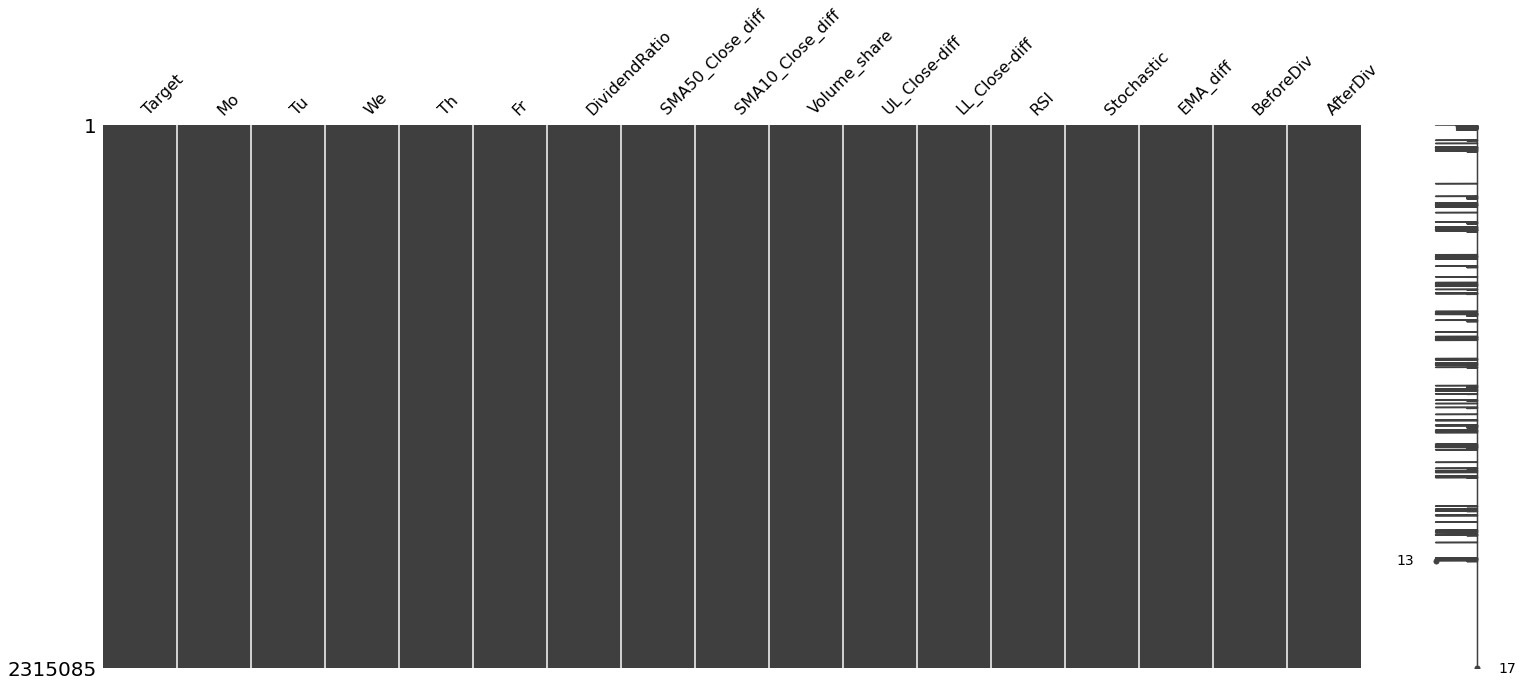

In [31]:
final13 = final12.drop(['Date','SecuritiesCode','Open','High','Low','Close','Volume',
                        'AdjustmentFactor','ExpectedDividend','SupervisionFlag','CumFactor',
                       'SMA50','SMA10','k','EMA12','EMA26','SMA14UP','SMA14DOWN','Lower_line','Upper_line',
                       'SD10','MACD','EMA9','tot_volume','ind_volume'], axis=1)
msno.matrix(final13)

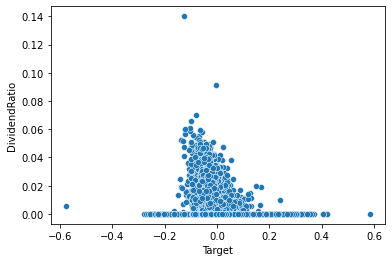

In [45]:
data1 =  final13[['Target','DividendRatio']]
sns.scatterplot(data=data1, x="Target", y="DividendRatio")
plt.show()

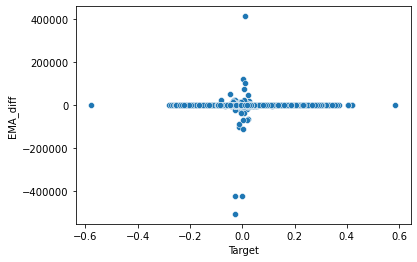

In [39]:
data1 =  final13[['Target','EMA_diff']]
sns.scatterplot(data=data1, x="Target", y="EMA_diff")
plt.show()

In [ ]:
final13.groupby('')

In [894]:
options

,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,NightSessionClose,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
DateCode,,,,,,,,,,,,,,,,,,,,,
20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0,0.0,0.0,0.0,...,1,2017-01-12,2017-01-13,480.0,478.4587,17.47360,17.5865,0.0091,0.0,0.0
20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2017-01-12,2017-01-13,575.0,571.1385,17.47360,16.5000,0.0091,0.0,0.0
20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2017-01-12,2017-01-13,680.0,677.3710,17.47360,15.8644,0.0091,0.0,0.0
20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2017-01-12,2017-01-13,795.0,791.0383,17.47360,15.2288,0.0091,0.0,0.0
20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2017-01-12,2017-01-13,910.0,909.9947,17.47360,14.5932,0.0091,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211203_199244018,2021-12-03,199244018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2024-12-12,2024-12-13,335.0,368.5305,24.70275,19.2442,0.1564,0.0,0.0
20211203_199245018,2021-12-03,199245018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2024-12-12,2024-12-13,1160.0,1253.3703,24.70275,19.0517,0.1564,0.0,0.0
20211203_199246018,2021-12-03,199246018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2024-12-12,2024-12-13,1015.0,1097.0436,24.70275,19.0956,0.1564,0.0,0.0


In [9]:
options1 = options.copy()
#Все опционы на Nikkei Stock Average (Nikkei 225) 
years = {'6':2021,'7':2022,'8':2023,'9':2024,'0':2025,'1':2026,'2':2027,'3':2028,'4':2029,'5':2030,'6':2031,'7':2032}
months = {'01':1,'02':2,'03':3,'04':4,'05':5,'06':6,'07':7,'08':8,'09':9,'10':10,'11':11,'12':12}
types = {'1':'Put featues','2':'Call features','3':'Put spot','4':'Call spot','5':'Put featues','6':'Features','7':'Call features','8':'Put spot','9':'Call spot'}

options1['OptionsCode'] = options1['OptionsCode'].apply(str)
options1['Contract_Type'] = [types[i[1]] for i in options1['OptionsCode']]
options1['Contract_Year'] = [years[i[2]] for i in options1['OptionsCode']]
options1['Ex_price'] = [i[5:7] for i in options1['OptionsCode']]

#option1 = options[options['Putcall'] == 1].groupby(['Date','OptionsCode'[:5]]).agg('sum')['OpenInterest']
#unique_numbers = set(options['Index'])
#unique_numbers



,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,NightSessionClose,...,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend,Contract_Type,Contract_Year,Contract_Month,Ex_price
DateCode,,,,,,,,,,,,,,,,,,,,,
20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0,0.0,0.0,0.0,...,478.4587,17.47360,17.5865,0.0091,0.0,0.0,Put spot,2027,01,00
20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,571.1385,17.47360,16.5000,0.0091,0.0,0.0,Put spot,2027,01,01
20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,677.3710,17.47360,15.8644,0.0091,0.0,0.0,Put spot,2027,01,02
20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,791.0383,17.47360,15.2288,0.0091,0.0,0.0,Put spot,2027,01,03
20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,909.9947,17.47360,14.5932,0.0091,0.0,0.0,Put spot,2027,01,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211203_199244018,2021-12-03,199244018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,368.5305,24.70275,19.2442,0.1564,0.0,0.0,Call spot,2024,24,40
20211203_199245018,2021-12-03,199245018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1253.3703,24.70275,19.0517,0.1564,0.0,0.0,Call spot,2024,24,50
20211203_199246018,2021-12-03,199246018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1097.0436,24.70275,19.0956,0.1564,0.0,0.0,Call spot,2024,24,60


In [19]:
put = options[options['Putcall'] == 1].groupby('Date').agg('sum')['OpenInterest'].reset_index()
put['PrevOpenInterest'] = put['OpenInterest'].shift(1)
put['Diff'] = (put['OpenInterest'] - put['PrevOpenInterest']) / put['PrevOpenInterest']
put

,Date,OpenInterest,PrevOpenInterest,Diff
0,2017-01-04,1060556,NaN,NaN
1,2017-01-05,1078001,1060556.0,0.016449
2,2017-01-06,1095976,1078001.0,0.016674
3,2017-01-10,1114157,1095976.0,0.016589
4,2017-01-11,1124142,1114157.0,0.008962
...,...,...,...,...
1197,2021-11-29,967505,953040.0,0.015178
1198,2021-11-30,974403,967505.0,0.007130
1199,2021-12-01,992617,974403.0,0.018692
1200,2021-12-02,996537,992617.0,0.003949


In [20]:
call = options[options['Putcall'] == 2].groupby('Date').agg('sum')['OpenInterest'].reset_index()
call['PrevOpenInterest'] = call['OpenInterest'].shift(1)
call['Diff'] = (call['OpenInterest'] - call['PrevOpenInterest']) / call['PrevOpenInterest']
call

,Date,OpenInterest,PrevOpenInterest,Diff
0,2017-01-04,876702,NaN,NaN
1,2017-01-05,878324,876702.0,0.001850
2,2017-01-06,883960,878324.0,0.006417
3,2017-01-10,888096,883960.0,0.004679
4,2017-01-11,896820,888096.0,0.009823
...,...,...,...,...
1197,2021-11-29,566549,559155.0,0.013224
1198,2021-11-30,571250,566549.0,0.008298
1199,2021-12-01,583558,571250.0,0.021546
1200,2021-12-02,590389,583558.0,0.011706
